In [12]:
import numpy as np
import random
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import torch.nn as nn
import pickle
import librosa
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Question 1

In [207]:
#Reference
#https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work
#https://levelup.gitconnected.com/how-to-split-an-image-into-patches-with-python-e1cf42cf4f77
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = 'data/MNIST'

In [208]:
class Q1Net(nn.Module):
  
  def __init__(self):

        super(Q1Net,self).__init__()        
        self.layer1 = nn.LSTM(input_size=49, hidden_size=64, num_layers=2, batch_first=True)   
        self.layer2 = nn.Linear(64,49)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

  def forward(self, output):
        
        (x, y) = self.layer1(output)
        #x = x.reshape(x.shape[1],-1)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x, y

In [209]:
class customData(datasets.MNIST):
  input1 = 28
  input2 = 28
  scale = 255
  mean = 0.1307
  std = 0.3081
  num1 = 7
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data2 = []
        self.shape = self.data.shape[0]
        self.unsqueeze = self.data.unsqueeze(1).float()
        self.data = self.unsqueeze.div(self.scale)
        self.norm = self.data.sub_(self.mean)
        self.data = self.norm.div_(self.std)
        self.data = self.data.reshape(self.shape, self.input1, self.input2)

        for item in self.data:
            self.data2.append(item.unfold(0, self.num1, self.num1).unfold(1, self.num1, self.num1).reshape(16, self.num1, self.num1).reshape(16, 49))
        self.data = torch.cat(self.data2).reshape(self.shape, 16, 49)
        del self.data2

        self.targets = self.targets
        self.data = self.data.to(dev)
  
  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self,id):
    item = self.data[id]
    return item[:15,:], item[1:,:]

In [210]:
# mnist_train=datasets.MNIST('mnist',
# train=True,
# download=True,
# transform = transforms.Compose([
# transforms.ToTensor(),
# transforms.Normalize((0.1307,), (0.3081,))
# ]))

# mnist_test=datasets.MNIST('mnist',
# train=False,
# download=True,
# transform=transforms.Compose([
# transforms.ToTensor(),
# transforms.Normalize((0.1307,), (0.3081,))
# ]))
mnist_train = customData(path, 
                         train=True, 
                         download=True)
mnist_test = customData(path, 
                        train=False, 
                        download=True)

In [211]:
def train_neural_network_Q1(model,epochs,batch_size,train_dataset,test_dataset,
                         lr,dev,activation):
    initial = 1
    stop = False
    valid_loss_final = []
    train_loss_final = []
    accuracy_final = []
    top = 0.98

    train_iterate = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_iterate = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    while ((initial <= epochs) and (stop==False)):
  
      train_loss = 0
      print("Epoch:", initial)

      for i, (x1, x2) in enumerate(train_iterate):

        optimizer.zero_grad()
        y1, y2 = model(x1)
        loss = activation(y1, x2)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      train_loss_final.append(train_loss/len(train_iterate.dataset))

      with torch.no_grad():
        test_loss = 0
        for x1, x2 in test_iterate:

          y1, y2 = model(x1)
          loss = activation(y1, x2)
          test_loss += loss.item()

        valid_loss_final.append(test_loss/len(test_iterate.dataset))
    
      #torch.save(self.model.state_dict(), '/content/network-mnist.pt')

      initial += 1

In [212]:
activation = nn.MSELoss()
batch_size = 256
epochs = 50
lr = 0.001
model = Q1Net().to(dev)
train_neural_network_Q1(model = model, train_dataset = mnist_train, test_dataset = mnist_test, epochs = epochs, batch_size = batch_size, lr = lr, activation = activation, dev = dev)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


In [219]:
test_iterate = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=1, shuffle=False)
lstm_img = []
input1 = 28
input2 = 28
num1 = 49
num2 = 8
with torch.no_grad():
    for x1, x2 in test_iterate:
        x1 = x1[0][:num2, :]
        x1_reshape = x1.reshape(1, num2, num1)
        for i in range(num2):
            y1, y2 = model(x1_reshape)
            x1_reshape = torch.cat((x1_reshape, y1[0][-1].reshape(1,1, num1)), 1)
        lstm_imgg = np.concatenate(x1_reshape.detach().cpu().numpy())
        lstm_reshape = lstm_imgg.reshape(-1,input1//7,input1//7,7,7)
        lstm_trans = lstm_reshape.transpose(0,1,3,2,4)
        lstm_trans_reshape = lstm_trans.reshape(-1,input1,input2)
        lstm_img.append(lstm_trans_reshape)

In [220]:
target = mnist_test.targets.numpy()
targ = {}
for i, j in enumerate(target):
    if j not in targ:
        targ[j] = [i]
    else:
        targ[j].append(i)

Prediction


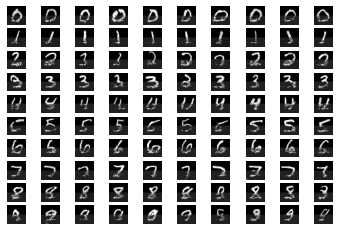

In [221]:
print("Prediction")
num1 = 10
for i in range(0,num1):
  if i in targ.keys():
    total = 0
    for j in targ[i]:
      plot = plt.subplot2grid((num1,num1),(i,total))
      total += 1
      plot.imshow(lstm_img[j][0], cmap='gray')
      plot.axis('off')
      if total == num1:
          break

Original


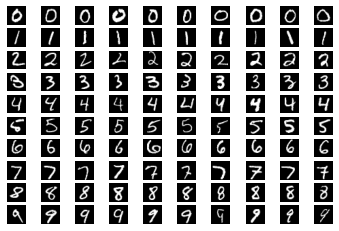

In [222]:
print("Original")
num1 = 10
for i in range(0,num1):
  if i in targ.keys():
    total = 0
    for j in targ[i]:
      plot = plt.subplot2grid((num1,num1),(i,total))
      total += 1        
      lstm_imgg = np.concatenate(mnist_test.data[j].detach().cpu().numpy())
      lstm_reshape = lstm_imgg.reshape(-1,input1//7,input1//7,7,7)
      lstm_trans = lstm_reshape.transpose(0,1,3,2,4)
      lstm_trans_reshape = lstm_trans.reshape(-1,input1,input2)
      plot.imshow(lstm_trans_reshape[0], cmap = "gray")
      plot.axis('off')
      if total == 10:
          break

# Question 2

In [138]:
from torch.autograd.variable import Variable
import numpy as np
import random
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import pickle
import librosa
from itertools import combinations
from itertools import product
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
from torch.utils import data


In [139]:
#Reference
#https://medium.com/bivek-adhikari/creating-custom-datasets-and-dataloaders-with-pytorch-7e9d2f06b660
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [140]:
units = 1024
K = 4

class VAE_Net(nn.Module):

  def __init__(self,input1,input2):

        super(VAE_Net,self).__init__()
        self.encode_input = nn.Linear(input1*input2, units)
        self.encode_hide1 = nn.Linear(units, units)
        self.encode_hide2 = nn.Linear(units, units)
        self.encode_hide3 = nn.Linear(units, units)
        self.encode_hide4 = nn.Linear(units, units)
        self.encode_output1 = nn.Linear(units, K)
        self.encode_output2 = nn.Linear(units, K)

        self.decode_input = nn.Linear(K, units)
        self.decode_hide1 = nn.Linear(units, units)
        self.decode_hide2 = nn.Linear(units, units)
        self.decode_hide3 = nn.Linear(units, units)
        self.decode_hide4 = nn.Linear(units, units)
        self.decode_output1 = nn.Linear(units, input1*input2)
              
  def encode(self, network):

      network = self.encode_input(network)
      network = F.relu(network)
      network = self.encode_hide1(network)
      network = F.relu(network)
      network = self.encode_hide2(network)
      network = F.relu(network)
      network = self.encode_hide3(network)
      network = F.relu(network)
      network = self.encode_hide4(network)
      network = F.relu(network)

      return (self.encode_output1(network), self.encode_output2(network))

  def decode(self, z):

        z = self.decode_input(z)
        z = F.relu(z)
        z = self.decode_hide1(z)
        z = F.relu(z)
        z = self.decode_hide2(z)
        z = F.relu(z)
        z = self.decode_hide3(z)
        z = F.relu(z)
        z = self.decode_hide4(z)
        z = F.relu(z)
        z = self.decode_output1(z)
        z = F.sigmoid(z)

        return z
  
  def reparam_tec(self, out1, log_var):
    std = torch.exp(log_var/2)
    eps = torch.randn_like(std)
    return out1 + eps * std

  def forward(self,network):
    mean, eps = self.encode(network.view(-1,784))
    z = self.reparam_tec(mean, eps)
    return self.decode(z), mean, eps

In [141]:
class customData(data.Dataset):
  
  def __init__(self,dat):
    dat = torch.tensor(dat, dtype=torch.float)
    self.data = dat.reshape(dat.shape[0], -1)

  def __getitem__(self,index):
    image = self.data[index,:]
    return image

  def __len__(self):
    return len(self.data)

In [142]:
mnist_train = customData(pickle.load(open("/content/drive/MyDrive/hw5_tr7.pkl", "rb")))
mnist_test = customData(pickle.load(open("/content/drive/MyDrive/hw5_te7.pkl", "rb"))) 

In [143]:
class autoEncoder():
  def __init__(self,train_dataset,test_dataset):

    self.train_iterate = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    self.test_iterate = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_dataset.__len__(), shuffle=True)


  def train_neural_network_Q2(self,epochs,batch_size,
                         lr,input1,input2,dev):
    initial = 1
    stop = False
    valid_loss_final = []
    train_loss_final = []
    accuracy_final = []
    top = 0.98

    self.model = VAE_Net(input1 = input1, input2 = input2).to(dev)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
    while ((initial <= epochs) and (stop==False)):
  
      train_loss = 0
      for train in self.train_iterate:

        train = train.to(dev)
      # img_reshape = img.reshape(-1,input1*input2).to(dev)
      # label = label.to(dev)
        optimizer.zero_grad()
        output_img, mean, eps = self.model.forward(train)
        loss = self.activation(output_img, train, mean, eps)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      train_loss_final.append(train_loss/len(self.train_iterate.dataset))

      with torch.no_grad():
        test_loss = 0
        for val in self.test_iterate:

          val = val.to(dev)
        # test_img_reshape = val_img.reshape(-1, input1*input2).to(dev)
        # val_label = val_label.to(dev)
          output_img, mean, eps = self.model.forward(val)
          loss = self.activation(output_img, val, mean, eps)
          test_loss += loss.item()

        valid_loss_final.append(test_loss/len(self.test_iterate.dataset))
    
      #torch.save(self.model.state_dict(), '/content/network-mnist.pt')

      initial += 1
    
  def activation(self,output_img, item, mean, esp):
    bce_loss = F.binary_cross_entropy(output_img, item.view(-1, 784), reduction='sum')
    kl_diverg = -0.5 * torch.sum(1 + esp - mean.pow(2) - esp.exp())
    return bce_loss + kl_diverg

In [144]:
input1 = 28
input2 = 28
units = 1024
K = 4
test_len = len(mnist_test)


batch_size = 512
epochs = 50
lr = 0.0001

vl = autoEncoder(train_dataset = mnist_train, test_dataset = mnist_test)

vl.train_neural_network_Q2(epochs = epochs, batch_size = batch_size, lr = lr, input1 = input1, input2 = input2, dev = dev)

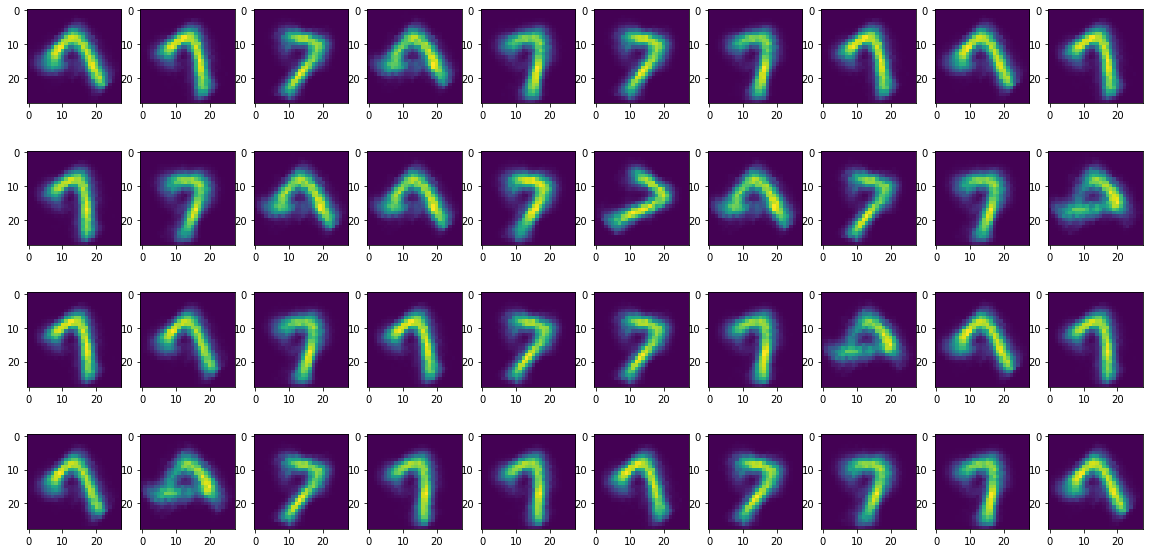

In [146]:
normal_rand = np.random.normal(0,1,size=4)
final_z = np.zeros((4,10,28,28))
z = torch.tensor(np.random.normal(0,1,size=(10,4)),dtype=torch.float).to(dev)
v1_decode = vl.model.decode(z)
v1_decode = v1_decode.reshape(-1,28,28).detach().cpu().numpy()

for item in range(0,4):
  z = np.zeros((10,4))

  for j in range(0,4):

    if(j == item):
      z[:,j] = np.random.normal(0,1,size=10)

    else:
      z[:,j] = np.full(10,normal_rand[j])
  z = torch.tensor(np.random.normal(0,1,size=(10,4)),dtype=torch.float).to(dev)
  v1_decode = vl.model.decode(z)
  final_z[item,:,:,:] = v1_decode.reshape(-1,28,28).detach().cpu().numpy()
fig, axes = plt.subplots(4,10,figsize=(20,10))

for item in range(0,4):
  for j in range(0,10):
    axis = axes[item,j]
    i = final_z[item,j,:,:]
    axis.imshow(i)

# Question 3

In [ ]:
#Reference
#https://medium.com/analytics-vidhya/step-by-step-implementation-of-conditional-generative-adversarial-networks-54e4b47497d6
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

bs = 32
mnist_train = MNIST('data', 
                    train=True, 
                    download=True, 
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
]))

train_iterate = DataLoader(mnist_train, batch_size=bs, shuffle=True)

mnist_test = MNIST('data', 
                    train=False, 
                    download=True, 
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
]))

test_bs = 10000
test_iterate = DataLoader(mnist_test, batch_size=test_bs, shuffle=True)

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 400),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        emb = self.label_emb(labels)
        x = torch.cat([x, emb], 1)
        final = self.model(x)
        return final.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        emb = self.label_emb(labels)
        x = torch.cat([z, emb], 1)
        final = self.model(x)
        return final.view(x.size(0), 28, 28)

In [ ]:
import torch
from torch.cuda import is_available
dev = torch.device('cuda:0' if is_available() else 'cpu')
sp = '/content/drive/MyDrive/DLS/v1_gen.pth'

In [ ]:
from sklearn.metrics import accuracy_score

def accuracy(pred,real):
    return accuracy_score(real.cpu().detach().numpy(),pred.cpu().detach().numpy()>0.5)
    
def train_neural_network_Q3(epochs,bs,input1,input2,dev):
  
  initial = 1
  fake_accuracy = []
  real_accuracy = []
  discrim_losses = []
  gen_losses = []

  for e in range(epochs):

      print('Current epoch:', str(e))
      for i, b in enumerate(train_iterate):
        
          img = b[0]
          lab = b[1]
          img_rea = img.to(dev)
          lab = lab.to(dev)
          loss_discrim = 0
          length = len(train_iterate)

          model_gen.train()
          model_discrim.train()

          randint_fake = np.random.randint(0, input2, bs)
          torch_ones = torch.ones(bs).to(dev)
          torch_zeros = torch.zeros(bs).to(dev)
          randn_fake = torch.randn(bs, input1).to(dev)

          optim_discrim.zero_grad()   

          output_d = model_discrim(img_rea, lab)
          loss_d_rea = loss_func_binary(output_d, torch_ones)
        
          lab_fake = torch.LongTensor(randint_fake).to(dev)
          img_fake = model_gen(randn_fake, lab_fake)
          output_d_fake = model_discrim(img_fake, lab_fake)
          loss_d_fak = loss_func_binary(output_d_fake, torch_zeros)
        
          loss_discrim = loss_d_rea + loss_d_fak
          loss_discrim.backward()
          optim_discrim.step()
          loss_discrim = loss_discrim.item()

          discrim_losses.append(loss_discrim)
        
          optim_generate.zero_grad()
          randn_g = torch.randn(bs, input1).to(dev)
          lab_fake = torch.LongTensor(randint_fake).to(dev)
          img_fake = model_gen(randn_g, lab_fake)
          output_g_fake = model_discrim(img_fake, lab_fake)
          loss_g_fak = loss_func_binary(output_g_fake, torch_ones)
          loss_g_fak.backward()
          optim_generate.step()
          loss_g_fak = loss_g_fak.item()

          gen_losses.append(loss_g_fak)
      
      model_gen.eval()
      model_discrim.eval()

      f_acc = 0
      r_acc = 0
      with torch.no_grad():
  
        for i, b in enumerate(test_iterate):
          # print(f_acc,r_acc,'!!')
        #Cal real acc
          img = b[0]
          lab = b[1]
          img_rea = img.to(dev)
          lab = lab.to(dev)
          loss_discrim = 0
          length = len(train_iterate)

          randint_fake = np.random.randint(0, input2, lab.shape[0])
          torch_ones = torch.ones(lab.shape[0]).to(dev)
          torch_zeros = torch.zeros(lab.shape[0]).to(dev)
          randn_fake = torch.randn(lab.shape[0], input1).to(dev)

          output_d = model_discrim(img_rea, lab)
          loss_d_rea = loss_func_binary(output_d, torch_ones)
          real_acc = accuracy(output_d,torch_ones)
        
          lab_fake = torch.LongTensor(randint_fake).to(dev)
          img_fake = model_gen(randn_fake, lab_fake)
          output_d_fake = model_discrim(img_fake, lab_fake)
          loss_d_fak = loss_func_binary(output_d_fake, torch_zeros)
          fake_acc = accuracy(output_d_fake, torch_zeros)
        
          loss_discrim = loss_d_rea + loss_d_fak
          loss_discrim = loss_discrim.item()

          f_acc += fake_acc
          r_acc += real_acc

      print("False_acc: ", f_acc/(i+1)*100)
      print("Real_acc: ", r_acc/(i+1)*100)

      fake_accuracy.append(f_acc/(i+1)*100)
      real_accuracy.append(r_acc/(i+1)*100)

      # fake_accuracy.append(fake_acc/(i+1))
      # real_accuracy.append(real_acc/(i+1))

  torch.save(model_gen.state_dict(), sp)

  return fake_accuracy, real_accuracy, discrim_losses, gen_losses
  

In [ ]:
from torch.optim import Adam
import torchvision

epochs = 50
batch_size = 32
input1 = 100
input2 = 10
learning_rate = 0.0001

model_gen = Generator()
model_discrim = Discriminator()
model_gen.to(dev)
model_discrim.to(dev)

loss_func_binary = nn.BCELoss()

optim_generate = Adam(model_gen.parameters(), lr = learning_rate)
optim_discrim = Adam(model_discrim.parameters(), lr = learning_rate)

fake_accuracy, real_accuracy, discrim_losses, gen_losses = train_neural_network_Q3(epochs = epochs, bs = batch_size, input1 = input1, input2 = input2, dev = dev)

Current epoch: 0
False_acc:  100.0
Real_acc:  99.0
Current epoch: 1
False_acc:  99.26
Real_acc:  99.94
Current epoch: 2
False_acc:  100.0
Real_acc:  98.74000000000001
Current epoch: 3
False_acc:  99.18
Real_acc:  99.02
Current epoch: 4
False_acc:  94.77
Real_acc:  99.38
Current epoch: 5
False_acc:  99.92
Real_acc:  95.35
Current epoch: 6
False_acc:  97.86
Real_acc:  95.6
Current epoch: 7
False_acc:  92.35
Real_acc:  97.58
Current epoch: 8
False_acc:  97.50999999999999
Real_acc:  96.74000000000001
Current epoch: 9
False_acc:  98.83999999999999
Real_acc:  92.81
Current epoch: 10
False_acc:  92.97999999999999
Real_acc:  92.44
Current epoch: 11
False_acc:  93.28
Real_acc:  92.09
Current epoch: 12
False_acc:  91.43
Real_acc:  89.34
Current epoch: 13
False_acc:  87.72
Real_acc:  89.96
Current epoch: 14
False_acc:  91.60000000000001
Real_acc:  86.11
Current epoch: 15
False_acc:  94.98
Real_acc:  85.44
Current epoch: 16
False_acc:  94.39
Real_acc:  82.41000000000001
Current epoch: 17
False_acc

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/DLS/fa.npy', fake_accuracy)
np.save('/content/drive/MyDrive/DLS/ra.npy', real_accuracy)
np.save('/content/drive/MyDrive/DLS/dl.npy', discrim_losses)
np.save('/content/drive/MyDrive/DLS/gl.npy', gen_losses)

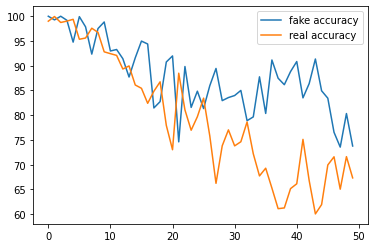

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(fake_accuracy, label='fake accuracy')
plt.plot(real_accuracy, label='real accuracy')
plt.legend()
plt.show()
plt.savefig('fake_real.png')

In [ ]:
len(discrim_losses)/50
dl = []
for i,j in enumerate(discrim_losses):
  if i%1875 == 0:
    dl.append(j)

print(len(dl))

len(gen_losses)/50
gl = []
for i,j in enumerate(gen_losses):
  if i%1875 == 0:
    gl.append(j)

print(len(gl))

50
50


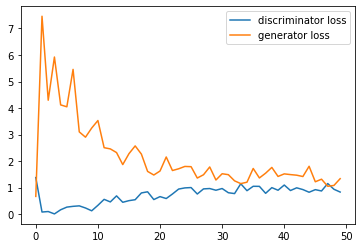

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(dl, label='discriminator loss')
plt.plot(gl, label='generator loss')
plt.legend()
plt.show()
plt.savefig('discrim_gen.png')

(-0.5, 301.5, 301.5, -0.5)

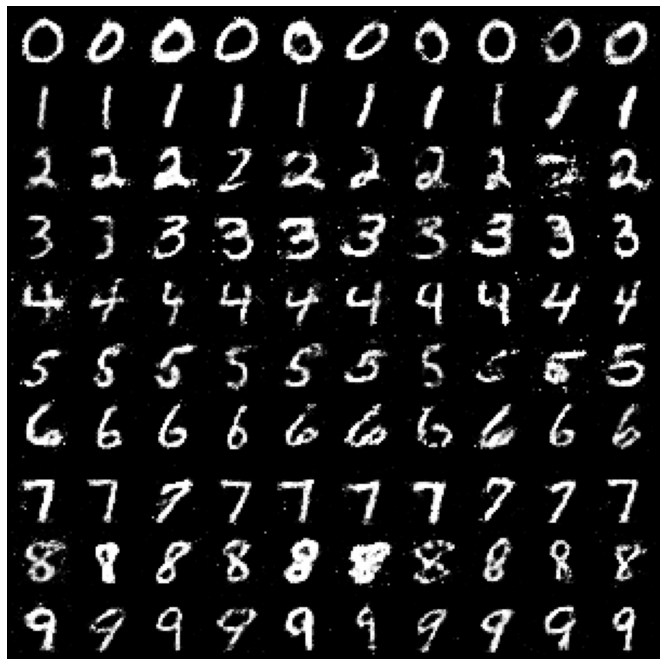

In [ ]:
randn_f = torch.randn(100, 100).to(dev)
tens = [i for i in range(10) for _ in range(10)]
lab = torch.LongTensor(tens).to(dev)
images = model_gen(randn_f, lab).unsqueeze(1)
img_grid = torchvision.utils.make_grid(images, nrow=10, normalize=True)
img_perm = img_grid.permute(1, 2, 0).cpu().data
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img_perm)
ax.axis('off')

# Question 4

In [ ]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

bs = 32
mnist_train = MNIST('data', 
                    train=True, 
                    download=True, 
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
]))

train_iterate = DataLoader(mnist_train, batch_size=bs, shuffle=True)

mnist_test = MNIST('data', 
                    train=False, 
                    download=True, 
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
]))

test_bs = 32
test_iterate = DataLoader(mnist_test, batch_size=test_bs, shuffle=True)

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        out = self.model(x)
        return out.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 200)
        x = z
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [ ]:
import torch
from torch.cuda import is_available
dev = torch.device('cuda:0' if is_available() else 'cpu')
sp = '/content/drive/MyDrive/DLS/v1_gen.pth'

In [ ]:
from torch.nn import MSELoss
rl = MSELoss()

In [ ]:
from sklearn.metrics import accuracy_score

def accuracy(pred,real):
    return accuracy_score(real.cpu().detach().numpy(),pred.cpu().detach().numpy()>0.5)
    
def train_neural_network_Q3(epochs,bs,input1,input2,dev):
  
  initial = 1
  fake_accuracy = []
  real_accuracy = []
  discrim_losses = []
  gen_losses = []

  for e in range(epochs):

      print('Current epoch:', str(e))
      for i, b in enumerate(train_iterate):
        
          img = b[0]
          lab = b[1]
          img_rea = img.to(dev)
          lab = lab.to(dev)
          loss_discrim = 0
          length = len(train_iterate)

          model_gen.train()
          model_discrim.train()

          randint_fake = np.random.randint(0, input2, bs)
          torch_ones = torch.ones(bs).to(dev)
          torch_zeros = torch.zeros(bs).to(dev)
          randn_fake = torch.randn(bs, input1).to(dev)

          optim_discrim.zero_grad()   

          output_d = model_discrim(img_rea, lab)
          loss_d_rea = loss_func_binary(output_d, torch_ones)
        
          randn_fake = torch.cat([randn_fake, img[:, :, 9:19, 9:19].reshape((img[:, :, 9:19, 9:19].shape[0], -1)).cuda()], 1)
          lab_fake = torch.LongTensor(randint_fake).to(dev)
          img_fake = model_gen(randn_fake, lab_fake)
          output_d_fake = model_discrim(img_fake, lab_fake)
          loss_d_fak = loss_func_binary(output_d_fake, torch_zeros)
        
          loss_discrim = loss_d_rea + loss_d_fak
          loss_discrim.backward()
          optim_discrim.step()
          loss_discrim = loss_discrim.item()

          discrim_losses.append(loss_discrim)
        
          optim_generate.zero_grad()

          randn_g = torch.randn(bs, input1).to(dev)
          lab_fake = torch.LongTensor(randint_fake).to(dev)


          mp = img[:, :, 9:19, 9:19].reshape((img[:, :, 9:19, 9:19].shape[0], -1)).cuda()
          # print(mp.shape, '***')
          randn_g = torch.cat([randn_g, mp], 1)
          # print(randn_g.shape,'$$$')
          img_fake = model_gen(randn_g, lab_fake)
          fmp = img_fake[:, 9:19, 9:19].reshape((img_fake[:, 9:19, 9:19].shape[0], -1)).cuda()
          
          output_g_fake = model_discrim(img_fake, lab_fake)
          loss_g_fak = loss_func_binary(output_g_fake, torch_ones)
          
          loss_g_fak += 10*rl(fmp, mp)

          loss_g_fak.backward()
          optim_generate.step()
          loss_g_fak = loss_g_fak.item()

          gen_losses.append(loss_g_fak)
      
      model_gen.eval()
      model_discrim.eval()

      f_acc = 0
      r_acc = 0
      with torch.no_grad():
  
        for i, b in enumerate(test_iterate):
        #Cal real acc
          img = b[0]
          lab = b[1]
          img_rea = img.to(dev)
          lab = lab.to(dev)
          loss_discrim = 0
          length = len(train_iterate)

          randint_fake = np.random.randint(0, input2, lab.shape[0])
          torch_ones = torch.ones(lab.shape[0]).to(dev)
          torch_zeros = torch.zeros(lab.shape[0]).to(dev)
          randn_fake = torch.randn(lab.shape[0], input1).to(dev)

          output_d = model_discrim(img_rea, lab)
          loss_d_rea = loss_func_binary(output_d, torch_ones)
          real_acc = accuracy(output_d,torch_ones)
        
          lab_fake = torch.LongTensor(randint_fake).to(dev)
          randn_fake = torch.cat([randn_fake, img[:, :, 9:19, 9:19].reshape((img[:, :, 9:19, 9:19].shape[0], -1)).cuda()], 1)
          img_fake = model_gen(randn_fake, lab_fake)
          output_d_fake = model_discrim(img_fake, lab_fake)
          loss_d_fak = loss_func_binary(output_d_fake, torch_zeros)
          fake_acc = accuracy(output_d_fake, torch_zeros)
        
          loss_discrim = loss_d_rea + loss_d_fak
          loss_discrim = loss_discrim.item()

          f_acc += fake_acc
          r_acc += real_acc

      print("False_acc: ", f_acc/(i+1)*100)
      print("Real_acc: ", r_acc/(i+1)*100)

      fake_accuracy.append(f_acc/(i+1)*100)
      real_accuracy.append(r_acc/(i+1)*100)

      # fake_accuracy.append(fake_acc/(i+1))
      # real_accuracy.append(real_acc/(i+1))


  return fake_accuracy, real_accuracy, discrim_losses, gen_losses
  

In [ ]:
model_gen = Generator()
model_discrim = Discriminator()
model_gen.to(dev)
model_discrim.to(dev)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=200, out_features=100, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
from torch.optim import Adam
import torchvision

epochs = 10
batch_size = 32
input1 = 100
input2 = 10
learning_rate = 0.0001

loss_func_binary = nn.BCELoss()

optim_generate = Adam(model_gen.parameters(), lr = learning_rate)
optim_discrim = Adam(model_discrim.parameters(), lr = learning_rate)

fake_accuracy, real_accuracy, discrim_losses, gen_losses = train_neural_network_Q3(epochs = epochs, bs = batch_size, input1 = input1, input2 = input2, dev = dev)


Current epoch: 0
False_acc:  99.97000000000001
Real_acc:  93.16999999999999
Current epoch: 1
False_acc:  96.06
Real_acc:  96.66
Current epoch: 2
False_acc:  98.02
Real_acc:  92.00000000000001
Current epoch: 3
False_acc:  95.45
Real_acc:  90.98
Current epoch: 4
False_acc:  84.33999999999999
Real_acc:  87.05999999999999
Current epoch: 5
False_acc:  93.42
Real_acc:  84.61000000000001
Current epoch: 6
False_acc:  87.03
Real_acc:  93.49000000000001
Current epoch: 7
False_acc:  88.4
Real_acc:  69.03999999999999
Current epoch: 8
False_acc:  91.57000000000002
Real_acc:  72.29999999999998
Current epoch: 9
False_acc:  76.08
Real_acc:  78.35


In [ ]:
from torch.optim import Adam
import torchvision

epochs = 20
batch_size = 32
input1 = 100
input2 = 10
learning_rate = 0.0001

loss_func_binary = nn.BCELoss()

optim_generate = Adam(model_gen.parameters(), lr = learning_rate)
optim_discrim = Adam(model_discrim.parameters(), lr = learning_rate)

fake_accuracy, real_accuracy, discrim_losses, gen_losses = train_neural_network_Q3(epochs = epochs, bs = batch_size, input1 = input1, input2 = input2, dev = dev)


Current epoch: 0
False_acc:  87.83
Real_acc:  81.14000000000001
Current epoch: 1
False_acc:  99.33999999999999
Real_acc:  98.03999999999998
Current epoch: 2
False_acc:  79.96
Real_acc:  92.58000000000003
Current epoch: 3
False_acc:  78.16
Real_acc:  82.2
Current epoch: 4
False_acc:  88.49000000000002
Real_acc:  74.65999999999998
Current epoch: 5
False_acc:  79.90000000000002
Real_acc:  80.4
Current epoch: 6
False_acc:  83.91999999999999
Real_acc:  72.67000000000002
Current epoch: 7
False_acc:  91.02
Real_acc:  60.89
Current epoch: 8
False_acc:  86.33000000000001
Real_acc:  71.83999999999997
Current epoch: 9
False_acc:  76.8
Real_acc:  74.91
Current epoch: 10
False_acc:  81.68
Real_acc:  73.79
Current epoch: 11
False_acc:  86.10999999999999
Real_acc:  66.73
Current epoch: 12
False_acc:  85.43999999999998
Real_acc:  74.51
Current epoch: 13
False_acc:  85.76000000000002
Real_acc:  71.83999999999997
Current epoch: 14
False_acc:  86.92999999999999
Real_acc:  69.02999999999999
Current epoch:

In [ ]:
from torch.optim import Adam
import torchvision

epochs = 10
batch_size = 32
input1 = 100
input2 = 10
learning_rate = 0.0001

loss_func_binary = nn.BCELoss()

optim_generate = Adam(model_gen.parameters(), lr = learning_rate)
optim_discrim = Adam(model_discrim.parameters(), lr = learning_rate)

fake_accuracy, real_accuracy, discrim_losses, gen_losses = train_neural_network_Q3(epochs = epochs, bs = batch_size, input1 = input1, input2 = input2, dev = dev)


Current epoch: 0
False_acc:  70.50999999999999
Real_acc:  80.51000000000002
Current epoch: 1
False_acc:  92.73
Real_acc:  57.35
Current epoch: 2
False_acc:  86.75999999999998
Real_acc:  70.06
Current epoch: 3
False_acc:  77.58
Real_acc:  72.6
Current epoch: 4
False_acc:  75.89999999999999
Real_acc:  74.55999999999999
Current epoch: 5
False_acc:  78.3
Real_acc:  72.44
Current epoch: 6
False_acc:  84.89999999999999
Real_acc:  61.58999999999999
Current epoch: 7
False_acc:  83.48
Real_acc:  64.60000000000001
Current epoch: 8
False_acc:  79.66999999999999
Real_acc:  69.44999999999999
Current epoch: 9
False_acc:  86.54000000000002
Real_acc:  60.620000000000005


In [ ]:
torch.save(model_gen.state_dict(), sp)
test_bs = 500
test_iterate = DataLoader(mnist_test, batch_size=test_bs, shuffle=True)

In [ ]:
d = dict()
for i in range(0,10):
  d[i] = []

print()
flag = 0
for item in test_iterate:
  cen = item[0]
  lab = item[1]

  print(lab.shape)
  print(cen.shape)
  for i in range(10):
    mask = lab == i
    # print(mask)
    limgs = cen[mask]
    print(limgs.shape)
    ri = 0
    d[i] = limgs[ri:ri+10]

  break


torch.Size([500])
torch.Size([500, 1, 28, 28])
torch.Size([51, 1, 28, 28])
torch.Size([59, 1, 28, 28])
torch.Size([58, 1, 28, 28])
torch.Size([54, 1, 28, 28])
torch.Size([51, 1, 28, 28])
torch.Size([42, 1, 28, 28])
torch.Size([40, 1, 28, 28])
torch.Size([45, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([48, 1, 28, 28])


In [ ]:
import torch
dl = list(d.values())
len(dl)
real_img = torch.cat(dl)
print(real_img.shape)

torch.Size([100, 1, 28, 28])


In [ ]:
for key in d:
  print(d[key].shape)

torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])


(-0.5, 301.5, 301.5, -0.5)

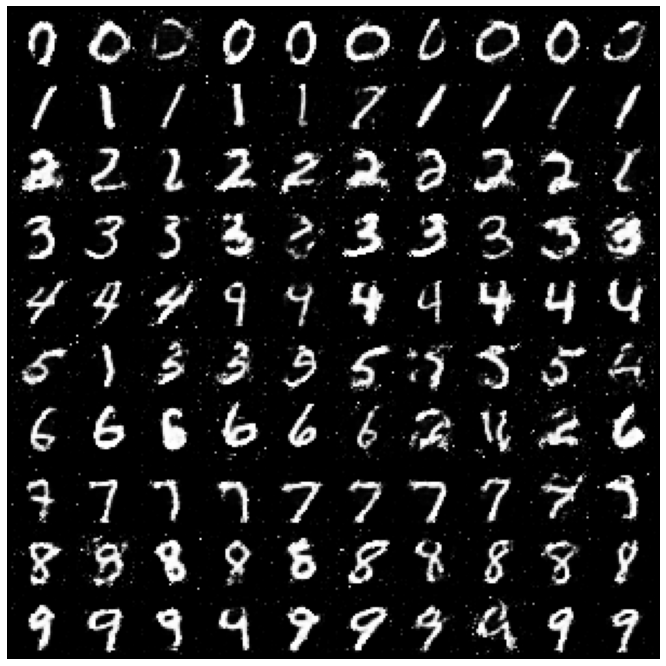

In [ ]:
randn_f = torch.randn(100, 100).to(dev)
randn_f = torch.cat([randn_f, real_img[:, :, 9:19, 9:19].reshape((real_img[:, :, 9:19, 9:19].shape[0], -1)).cuda()], 1)
tens = [i for i in range(10) for _ in range(10)]
lab = torch.LongTensor(tens).to(dev)
images = model_gen(randn_f, lab).unsqueeze(1)
img_grid = torchvision.utils.make_grid(images, nrow=10, normalize=True)
img_perm = img_grid.permute(1, 2, 0).cpu().data
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img_perm)
ax.axis('off')

(-0.5, 301.5, 301.5, -0.5)

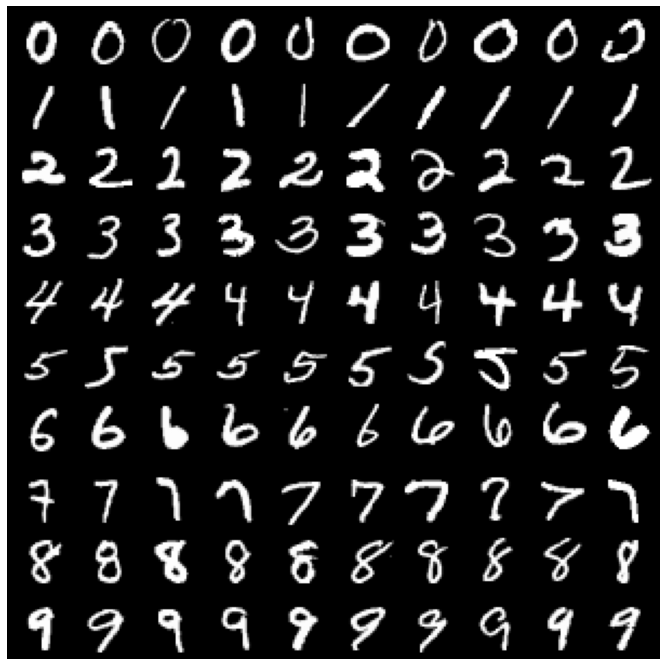

In [ ]:
#Real Images
img_grid = torchvision.utils.make_grid(real_img, nrow=10, normalize=True)
img_perm = img_grid.permute(1, 2, 0).cpu().data
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img_perm)
ax.axis('off')